## Imports

In [3]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy import signal
from scipy.stats import zscore


Open file and plot an event

In [41]:
with h5py.File('selected_events.h5', 'r') as fin:

    waveforms = fin.get('waveforms')[:]
    event_types = fin.get('type')[:]
    p_start = fin.get('p_start')[:]
    s_start = fin.get('s_start')[:]
    magnitude = fin.get('mag')[:]

    print(f'Waveforms data shape: {waveforms.shape}')
    print(f'-> {waveforms.shape[0]} events, {waveforms.shape[1]} data points per channel, {waveforms.shape[2]} channels')




Waveforms data shape: (10, 6000, 3)
-> 10 events, 6000 data points per channel, 3 channels


In [70]:
def plot_event(waveform, event_type, p_start, s_start, mag):

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 6))
    fig.subplots_adjust(hspace=0)

    sampling_rate = 100.
    time_points = np.arange(len(waveform)) / sampling_rate

    for channel_num, channel_name in enumerate(['E', 'N', 'Z']):

        axes[channel_num].plot(time_points, waveform[:, channel_num])

        if p_start is not None:
            p_arrival = axes[channel_num].axvline(p_start / sampling_rate, color='tab:orange', label='P arrival')
        if s_start is not None:
            s_arrival = axes[channel_num].axvline(s_start / sampling_rate, color='tab:red', label='S arrival')

        axes[channel_num].set_ylabel(channel_name)
        
    if p_arrival is not None:
        axes[0].legend(handles=[p_arrival, s_arrival], loc='upper right')
    
    title = f'Earthquake, mag {mag:.1f}' if event_type == 1 else 'Noise'
    plt.suptitle(title)
    
    axes[2].set_xlabel('Time [s]')


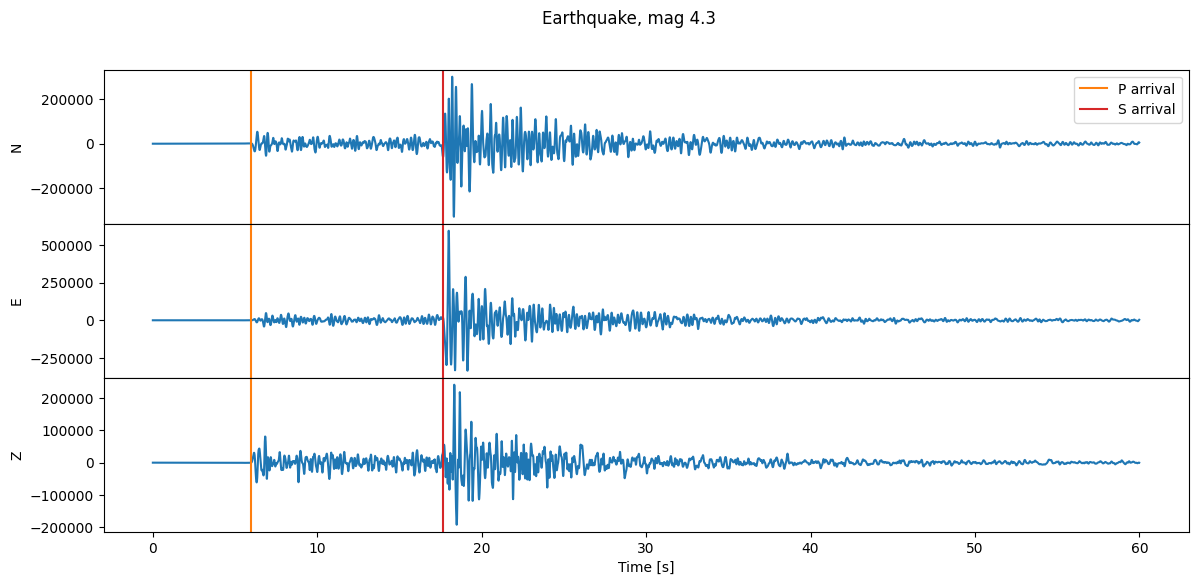

In [71]:
plot_event(waveforms[1], event_types[1], p_start[1], s_start[1], magnitude[1])

STA/LTA detection

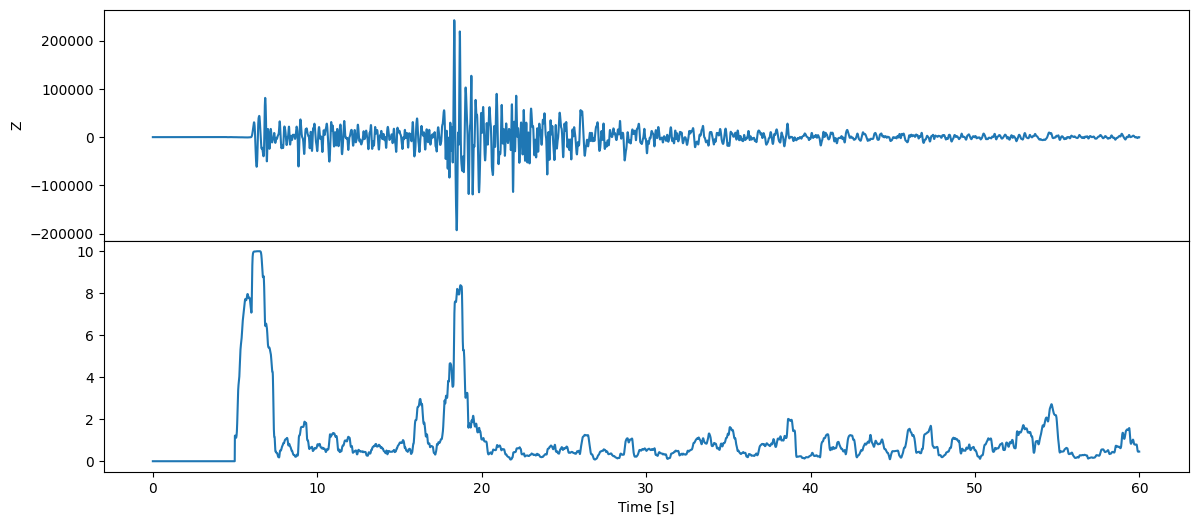

In [100]:
from obspy.signal.trigger import classic_sta_lta

def plot_sta_lta(waveform):

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(14, 6))
    fig.subplots_adjust(hspace=0)

    sampling_rate = 100.
    time_points = np.arange(len(waveform)) / sampling_rate

    #sta_lta = sta_lta_detect(waveform[:, 2], int(0.5*sampling_rate), int(5.0*sampling_rate))
    sta_lta = classic_sta_lta(waveform[:, 2], int(0.5*sampling_rate), int(5.0*sampling_rate))
    
    axes[0].plot(time_points, waveform[:, 2])
    axes[1].plot(time_points, sta_lta)

    axes[0].set_ylabel('Z')
    axes[1].set_ylabel('STA/LTA ratio')
        
    
    axes[1].set_xlabel('Time [s]')


plot_sta_lta(waveforms[1])

Cross-correlation

waveform.shape: (6000,)
template.shape: (2263,)
corr.shape: (6000,)


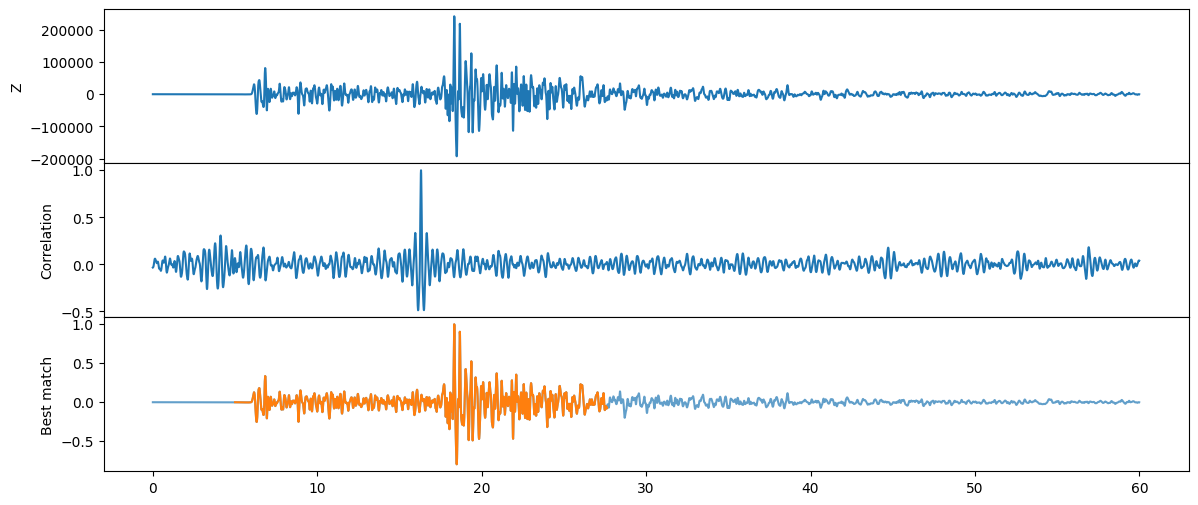

In [129]:
from obspy.signal.cross_correlation import correlate_template

def plot_correlation(waveform, template):

    print('waveform.shape:', waveform.shape)
    print('template.shape:', template.shape)

    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(14, 6))
    fig.subplots_adjust(hspace=0)

    sampling_rate = 100.
    time_points = np.arange(len(waveform)) / sampling_rate

    corr = correlate_template(waveform, template, mode='same')
    max_corr_index = np.argmax(corr) - len(template)//2
    max_corr_time_points = (np.arange(len(template)) + max_corr_index) / sampling_rate
    
    print('corr.shape:', corr.shape)
    
    axes[0].plot(time_points, waveform)
    axes[1].plot(time_points, corr)
    axes[2].plot(time_points, waveform / np.max(waveform), alpha=0.7)
    axes[2].plot(max_corr_time_points, template / np.max(template), color='tab:orange')

    axes[0].set_ylabel('Z')
    axes[1].set_ylabel('Correlation')
    axes[2].set_ylabel('Best match')
        
    axes[1].set_xlabel('Time [s]')    


# As our template, start 1 s before the P arrival and stop 10 s after the S arrival.
template = waveforms[1, :, 2]
template_p_start = p_start[1]
template_s_start = s_start[1]
template = template[template_p_start - 1*100 : template_s_start + 10*100]

plot_correlation(waveforms[1, :, 2], template)

## TODO make it easy to test different events 
